<a href="https://colab.research.google.com/github/girija2204/DLTopics/blob/master/greener_delhi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install arcgis

  Using cached https://files.pythonhosted.org/packages/c5/8f/51e89ce52a085483359217bc72cdbf6e75ee595d5b1d4b5ade40c7e018b8/jsonschema-3.2.0-py2.py3-none-any.whl
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0


In [27]:
%matplotlib inline

import pandas as pd
from datetime import datetime
from IPython.display import Image
import matplotlib.pyplot as plt

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geocoding import geocode

In [28]:
gis = GIS("https://www.arcgis.com", "girija2204", "Girija2204@")

In [29]:
landsat_data = gis.content.get("d9b466d6a9e647ce8d1dd5fe12eb434b")
landsat_data.layers

[<ImageryLayer url:"https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer">]

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
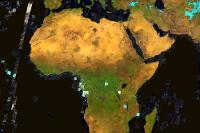

In [30]:
landsat_data

In [31]:
landsat_data.type

'Image Service'

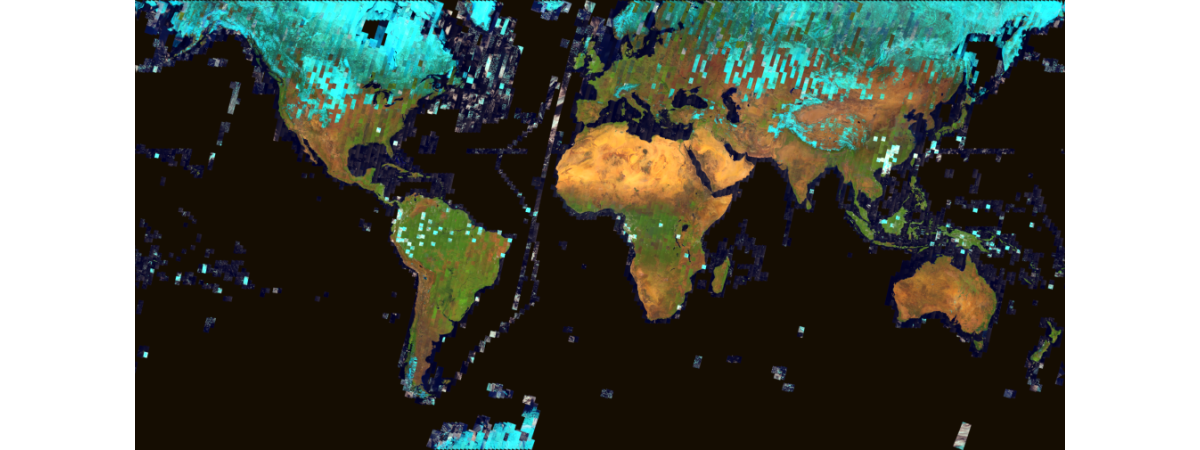

In [32]:
landsat_data.layers[0]

In [33]:
for property in landsat_data.layers[0].properties:
  print(property)

currentVersion
serviceDescription
name
description
extent
initialExtent
fullExtent
timeInfo
pixelSizeX
pixelSizeY
bandCount
pixelType
minPixelSize
maxPixelSize
copyrightText
serviceDataType
minValues
maxValues
meanValues
stdvValues
objectIdField
fields
capabilities
defaultMosaicMethod
allowedMosaicMethods
sortField
sortValue
mosaicOperator
maxDownloadSizeLimit
defaultCompressionQuality
defaultResamplingMethod
maxImageHeight
maxImageWidth
maxRecordCount
maxDownloadImageCount
maxMosaicImageCount
allowRasterFunction
rasterFunctionInfos
rasterTypeInfos
mensurationCapabilities
hasHistograms
hasColormap
hasRasterAttributeTable
minScale
maxScale
exportTilesAllowed
hasMultidimensions
supportsStatistics
supportsAdvancedQueries
editFieldsInfo
ownershipBasedAccessControlForRasters
allowComputeTiePoints
useStandardizedQueries
advancedQueryCapabilities
spatialReference


In [34]:
llayer = landsat_data.layers[0]
# print(llayer.properties['rasterFunctionInfos'][0].get('name'))
for rasterFunction in llayer.properties['rasterFunctionInfos']:
  print(rasterFunction.get('name'))

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA
Agriculture
Bathymetric
Color Infrared
Geology
Natural Color
Short-wave Infrared
NDVI Colorized
Normalized Difference Moisture Index Colorized
NDVI Raw
NBR Raw
Band 10 Surface Temperature in Fahrenheit
Band 11 Surface Temperature in Fahrenheit
Band 10 Surface Temperature in Celsius
Band 11 Surface Temperature in Celsius
None


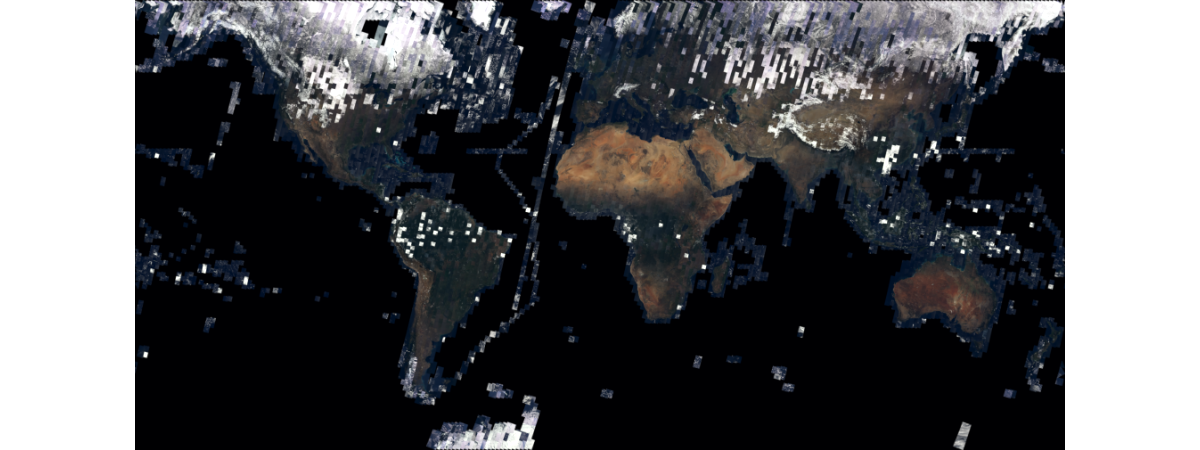

In [35]:
apply(llayer,'Natural Color with DRA')

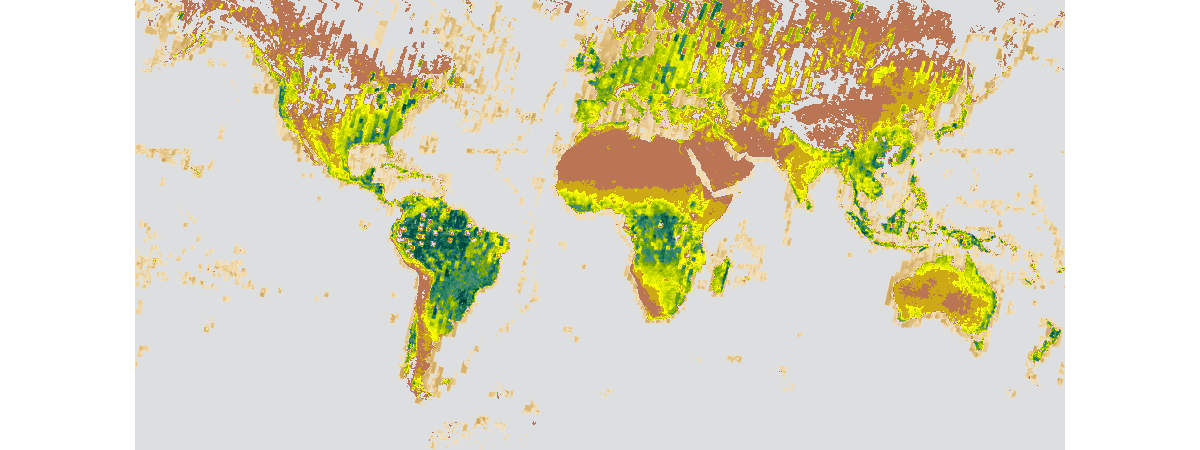

In [36]:
apply(llayer, 'NDVI Colorized')

In [37]:
boundaries = gis.content.get("3013e4533dc64a848159cafe7bc2de84")

In [38]:
delhi_geocode = geocode("New Delhi, India", out_sr=llayer.properties.spatialReference)
len(delhi_geocode)
area = delhi_geocode[0]
area['extent']
# llayer.extent = area['extent']
# llayer

{'xmax': 8623165.092412425,
 'xmin': 8568395.902942136,
 'ymax': 3359993.829849401,
 'ymin': 3297594.44082927}

In [42]:
state_boundaries = boundaries.layers[1]
delhi = state_boundaries.query(where="NAME='NCT of Delhi'")
delhi_geom = delhi.features[0].geometry
delhi_geom['spatialReference'] = {'wkid':4326}
# delhi_geom = delhi.features[0].geometry
# delhi_geom['spatialReference'] = {'wkid':4326}
# delhi.features[0].extent = area['extent']

In [43]:
selected = llayer.filter_by(where="(Category=1) AND (CloudCover <= 0.05)",
                 time=[datetime(2015, 1, 1),datetime(2017, 12, 31)],
                 geometry=arcgis.geometry.filters.intersects(area['extent']))
df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,Shape_Length,Shape_Area,SHAPE
0,2632348,2015-02-12 05:18:41,LC81460402015043LGN01_MTL,0.0004,43,851977.814994,4.532437e+10,"{""rings"": [[[8801347.41, 3442187.4860000014], ..."
1,2632350,2015-02-12 05:19:05,LC81460412015043LGN01_MTL,0.0016,43,840668.249829,4.410776e+10,"{""rings"": [[[8758841.250500001, 3259666.206900..."
2,2632351,2015-02-28 05:19:02,LC81460412015059LGN01_MTL,0.0050,59,840872.586846,4.413154e+10,"{""rings"": [[[8754496.146000002, 3260317.861200..."
3,2927742,2015-03-23 05:24:35,LC81470402015082LGN01_MTL,0.0000,82,851895.537862,4.531714e+10,"{""rings"": [[[8624359.6292, 3442972.474100001],..."
4,2643023,2015-04-08 05:24:24,LC81470402015098LGN01_MTL,0.0004,98,851736.398230,4.530057e+10,"{""rings"": [[[8624359.229600001, 3442970.772500..."
...,...,...,...,...,...,...,...,...
71,2095534,2017-10-31 05:19:33,LC81460412017304LGN00_MTL,0.0335,304,840790.091989,4.414146e+10,"{""rings"": [[[8754361.912, 3260262.332699999], ..."
72,2203649,2017-11-23 05:25:14,LC81470402017327LGN00_MTL,0.0333,327,852242.226027,4.535328e+10,"{""rings"": [[[8627133.4597, 3442780.260499999],..."
73,2206118,2017-12-02 05:19:00,LC81460402017336LGN00_MTL,0.0015,336,851555.400431,4.528033e+10,"{""rings"": [[[8800038.6758, 3442628.6884000003]..."
74,2211732,2017-12-09 05:25:11,LC81470402017343LGN00_MTL,0.0099,343,852179.154208,4.532813e+10,"{""rings"": [[[8626952.113400001, 3442914.852600..."


In [44]:
delhi_image = llayer.filter_by("OBJECTID=2752790") # 2017-10-15

In [45]:
def apply_transformations(dated_layer):
  dated_layer_ndviraw = apply(dated_layer,"NDVI Raw")
  dated_layer_clipped = clip(dated_layer_ndviraw, delhi_geom)
  dated_layer_clipped.extent = area['extent']
  dated_layer_clipped_remapped = remap(dated_layer_clipped,
      input_ranges=[0.4,0.5, 0.5, 1],
      output_values=[1, 2])
  dated_layer_clipped_colormapped = colormap(dated_layer_clipped_remapped,colormap=[[1, 124, 252, 0], [2, 0, 102, 0]], astype='u8')
  return dated_layer_clipped_colormapped

In [46]:
delhi_image_2927742 = llayer.filter_by("OBJECTID=2927742") # 2015-03-23
delhi_image_2678985 = llayer.filter_by("OBJECTID=2678985") # 2015-08-30
delhi_image_2752790 = llayer.filter_by("OBJECTID=2752790") # 2016-03-09
delhi_image_2945298 = llayer.filter_by("OBJECTID=2945298") # 2016-10-19
delhi_image_2974179 = llayer.filter_by("OBJECTID=2974179") # 2017-03-05
delhi_image_2095534 = llayer.filter_by("OBJECTID=2095534") # 2017-10-31

In [47]:
cm_delhi_image_2927742 = apply_transformations(delhi_image_2927742)
cm_delhi_image_2678985 = apply_transformations(delhi_image_2678985)
cm_delhi_image_2752790 = apply_transformations(delhi_image_2752790)
cm_delhi_image_2945298 = apply_transformations(delhi_image_2945298)
cm_delhi_image_2974179 = apply_transformations(delhi_image_2974179)
cm_delhi_image_2095534 = apply_transformations(delhi_image_2095534)

In [48]:
delhi_ndviraw = apply(delhi_image,"NDVI Raw")
delhi_clip = clip(delhi_ndviraw, delhi_geom)
delhi_clip.extent = area['extent']
# delhi_clip

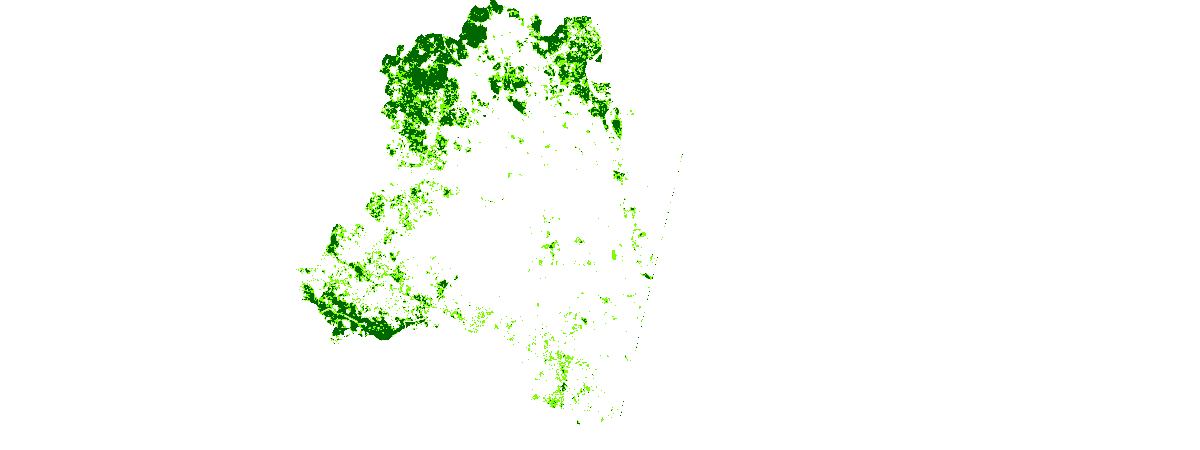

In [49]:
delhi_clip_remapped = remap(delhi_clip,
      input_ranges=[0.4,0.5, 0.5, 1],
      output_values=[1, 2])
delhi_clip_colormapped = colormap(delhi_clip_remapped,colormap=[[1, 124, 252, 0], [2, 0, 102, 0]], astype='u8')
delhi_clip_colormapped

In [ ]:
# delhi_clip_colormapped.draw_graph()

In [50]:
map2 = gis.map('New Delhi, India')
map2.add_layer(delhi_clip_colormapped)
map2.legend = True
map2.export_to_html('gifg.html')

True

In [51]:
def layer_export_to_html(layer,name):
  map = gis.map('New Delhi, India')
  map.add_layer(layer)
  map.legend = True
  map.export_to_html(f'{name}.html')

In [52]:
layer_export_to_html(cm_delhi_image_2927742,'cm_delhi_image_2927742')
layer_export_to_html(cm_delhi_image_2678985,'cm_delhi_image_2678985')
layer_export_to_html(cm_delhi_image_2752790,'cm_delhi_image_2752790')
layer_export_to_html(cm_delhi_image_2945298,'cm_delhi_image_2945298')
layer_export_to_html(cm_delhi_image_2974179,'cm_delhi_image_2974179')
layer_export_to_html(cm_delhi_image_2095534,'cm_delhi_image_2095534')

In [53]:
landsat_data.layers[0].properties

{
  "currentVersion": 10.61,
  "serviceDescription": "Multispectral Landsat image service covering the landmass of the World. This service includes scenes from Landsat 8 and Global Land Survey (GLS) data from epochs 1990, 2000, 2005 and 2010 at 30 meter resolution as well as GLS 1975 at 60 meter resolution. GLS datasets are created by the United States Geological Survey (USGS) and the National Aeronautics and Space Administration (NASA) using Landsat images. This service can be used for mapping and change detection of urban growth, change of natural resources and comparing Landsat 8 imagery with GLS data.  Using on-the-fly processing, the raw DN values are transformed to scaled (0 - 10000) apparent reflectance values and then different service based renderings for band combinations and indices are applied. The band names are in line with Landsat 8 bands; GLS data band names are mapped along the same lines.",
  "name": "Landsat/MS",
  "description": "Multispectral Landsat image service 

In [54]:
gis.content.search("title: ScientificData/SeaTemperature", "Imagery Layer", outside_org=True)

[]